In [90]:
import sys
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

from utils.dbutils import get_drought_codes_table
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# Set the working directory to the script's location
stations = get_drought_codes_table('table_stations')
# Create a GeoDataFrame from the stations DataFrame
stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
stations_gdf.set_crs(epsg=4326, inplace=True)

# convert freeze and thaw dataframes to geoDataFrames with datetime stamps
freeze = get_drought_codes_table('freeze_up')
freeze["freeze_date"] = pd.to_datetime(freeze["freeze_date"])
freeze["geometry"] = stations_gdf.loc[freeze.loc[:,"station_id"].values,:].loc[:,"geometry"].values
freeze = gpd.GeoDataFrame(freeze, geometry="geometry")

# Convert dc_freeze to integer, handling missing or invalid values
freeze["dc_freeze"] = pd.to_numeric(freeze["dc_freeze"], errors='coerce').astype('Int64')

thaw = get_drought_codes_table('snow_free')
thaw["snowfree_date"] = pd.to_datetime(thaw["snowfree_date"])
thaw["geometry"] = stations_gdf.loc[thaw.loc[:,"station_id"].values,:].loc[:,"geometry"].values
thaw = gpd.GeoDataFrame(thaw, geometry="geometry")
thaw["dc_startup"] = pd.to_numeric(thaw["dc_startup"], errors='coerce').astype('Int64')


constants = get_drought_codes_table('dc_constants')



In [89]:
thaw

,station_id,snowfree_date,overwinter_precip,dc_startup,date_update,Notes,geometry
id,,,,,,,
1,19,2003-05-20,113.3,54,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
2,19,2004-05-12,131.7,15,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
3,19,2005-05-17,106.2,111,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
4,19,2006-05-25,143.1,15,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
5,19,2007-05-22,75.9,96,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
...,...,...,...,...,...,...,...
789,12,2012-04-27,77.4,15,2025-03-19,ECCC CYJF,POINT (-123.47267 60.23578)
790,12,2013-05-03,,15,2025-03-19,no data,POINT (-123.47267 60.23578)
791,12,2019-05-01,54.8,225,2025-03-19,ECCC CYJF,POINT (-123.47267 60.23578)


In [ ]:

stations_gdf.explore()

In [107]:
idx = (freeze["freeze_date"].dt.year == year) & freeze["dc_freeze"].notnull()
values = freeze.loc[idx, "dc_freeze"].astype(float).values
lats = freeze.loc[idx, "geometry"].y
lons = freeze.loc[idx, "geometry"].x





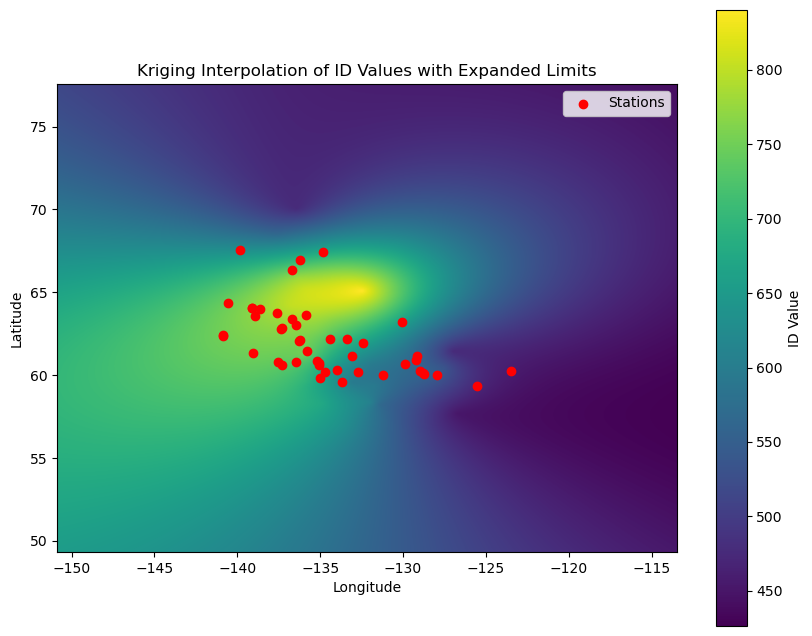

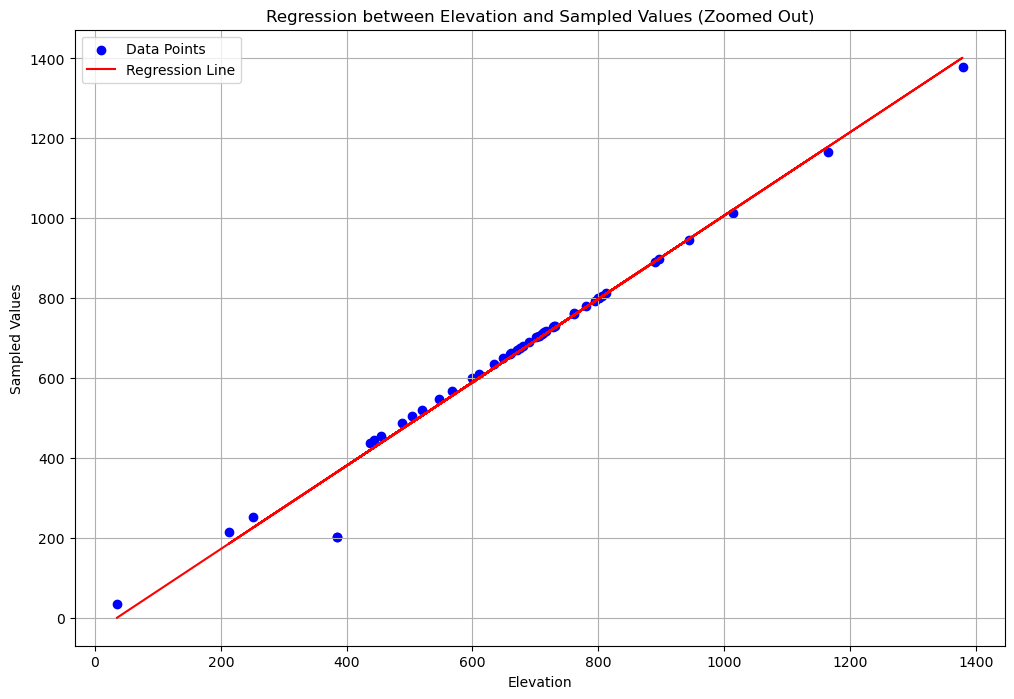

In [ ]:

# Extract coordinates and id values
lons = stations_gdf['longitude'].values
lats = stations_gdf['latitude'].values
values = stations_gdf['elevation'].values


def point_to_grid(lons, lats, values):
    # Ensure input arrays are numpy arrays
    lons = np.array(lons)
    lats = np.array(lats)
    values = np.array(values)

    # Check if input arrays are not empty
    if lons.size == 0 or lats.size == 0 or values.size == 0:
        raise ValueError("Input arrays must not be empty.")

    # Perform Kriging interpolation
    OK = OrdinaryKriging(lons, lats, values, variogram_model='linear', verbose=False, enable_plotting=False, variogram_function="gaussian")
    buffer = 10   # Approximate conversion from km to degrees
    grid_x, grid_y = np.meshgrid(
        np.linspace(lons.min() - buffer, lons.max() + buffer, 1000),
        np.linspace(lats.min() - buffer, lats.max() + buffer, 1000)
    )

    # Execute Kriging and handle potential errors
    try:
        grid_z, ss = OK.execute('grid', grid_x[0, :], grid_y[:, 0])
    except Exception as e:
        raise RuntimeError(f"Kriging interpolation failed: {e}")

    return grid_x, grid_y, grid_z

grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
# Plot the results with expanded x and y limits
plt.figure(figsize=(10, 8))
plt.imshow(grid_z.T, extent=(stations_gdf['longitude'].min() - buffer, stations_gdf['longitude'].max() + buffer,
                             stations_gdf['latitude'].min() - buffer, stations_gdf['latitude'].max() + buffer),
           origin='lower', cmap='viridis')

plt.colorbar(label='ID Value')
plt.scatter(stations_gdf['longitude'], stations_gdf['latitude'], c='red', label='Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Kriging Interpolation of ID Values with Expanded Limits')
plt.show()

# Sample the interpolated grid at the station locations
sampled_values, _ = OK.execute('points', lons, lats)

# Add the sampled values to the stations GeoDataFrame
stations_gdf['sampled_values'] = sampled_values

# Display the updated GeoDataFrame
# Plot regression between elevation and sampled_values
plt.figure(figsize=(12, 8))
plt.scatter(stations_gdf['elevation'], stations_gdf['sampled_values'], color='blue', label='Data Points')
m, b = np.polyfit(stations_gdf['elevation'], stations_gdf['sampled_values'], 1)
plt.plot(stations_gdf['elevation'], m * stations_gdf['elevation'] + b, color='red', label='Regression Line')
plt.xlabel('Elevation')
plt.ylabel('Sampled Values')
plt.title('Regression between Elevation and Sampled Values (Zoomed Out)')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd


# download basin shapefiles from WSC and merge them into a single GeoDataFrame
output_dir = Path().resolve() / "data/basins"
os.makedirs(output_dir, exist_ok=True)

url = "https://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/HydrometricNetworkBasinPolygons/shp/"
# Send a GET request to the URL with SSL verification disabled
response = requests.get(url, verify=False)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find all links on the page
links = soup.find_all('a')

# Extract and print file names
files = [link.get('href') for link in links if link.get('href') and link.get('href').endswith('.zip')]
# Extract numbers from file names

file_selection = [7, 8, 9, 10]
files = [file for file in files if int(''.join(filter(str.isdigit, file))) in file_selection]


for file in files:
    file_path = os.path.join(output_dir, file)
    if not os.path.exists(file_path):
        file_url = os.path.join(url, file)
        response = requests.get(file_url, verify=False)
        with open(file_path, 'wb') as f:
            f.write(response.content)

# Load the shapefile from the zip file
# Load all shapefiles from the zip files in the data/basins directory
gdfs = []
for file in files:
    file_path = output_dir / file
    gdf = gpd.read_file(f"zip://{file_path}", layer=0)
    gdfs.append(gdf)

# Merge all GeoDataFrames into a single GeoDataFrame
basins = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

c:\Users\esniede\Documents\github\YGwater\.conda\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'collaboration.cmc.ec.gc.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'WS_USRNM': '"yukon_RT"',
 'WS_PWD': '"Data#0225"',
 'ECCCUSER': '"nhs_partner"',
 'ECCCPASS': '"N0Lvr!p@"',
 'TZ': '"MST"',
 'aquacacheHost': '"10.250.12.154"',
 'aquacachePort': '"5432"',
 'aquacacheUser': '"public_reader"',
 'aquacachePass': '"aquacache"',
 'aquacacheAdminUser': '"admin"',
 'aquacacheAdminPass': '"SnowFa11ing"',
 'snowHost': '"199.247.132.26"',
 'snowPort': '"5432"',
 'snowAdminUser': '"admin"',
 'snowAdminPass': '"SnowFa11ing"',
 'snowUser': '"snow_reader"',
 'snowPass': '"snow"'}

In [27]:
from pathlib import Path
from sqlalchemy import create_engine, text
from shapely import wkt

def load_rconfig(renviron_path = Path.home() / "Documents" / ".Renviron"):
    # Define the path to the .Renviron file in the "My Documents" directory
    # Check if the file exists
    if renviron_path.exists():
        # Read the .Renviron file
        with open(renviron_path, 'r') as file:
            renviron_content = [line.strip() for line in file.readlines()]
    env_config = {v[0]: v[1].strip('"') for v in [line.split('=') for line in renviron_content if '=' in line]}
    # Convert numeric values to their appropriate types
    for key, value in env_config.items():
        if value.isdigit():
            env_config[key] = int(value)
        else:
            try:
                env_config[key] = float(value)
            except ValueError:
                pass
    return env_config

# Load database configuration from .Renviron
db_config = load_rconfig()
db_url = f"postgresql://{db_config['aquacacheUser']}:{db_config['aquacachePass']}@{db_config['aquacacheHost']}:{db_config['aquacachePort']}/aquacache"

# Create a database engine
engine = create_engine(db_url)

gdf = {}
res = []
polys = []
# Test the connection by listing tables
with engine.connect() as connection:
    geom_results = connection.execute(text("SELECT ST_AsText(geom) as geom FROM vectors WHERE layer_name = 'Drainage basins';"))
    results = connection.execute(text("SELECT * FROM vectors WHERE layer_name = 'Drainage basins';"))
    
    for geom_row, row in zip(geom_results, results):
        polys.append(wkt.loads(geom_row)[0])
        res.append(row)
gdf = gpd.GeoDataFrame(res, geometry=polys, crs="epsg:4269")


<Axes: >

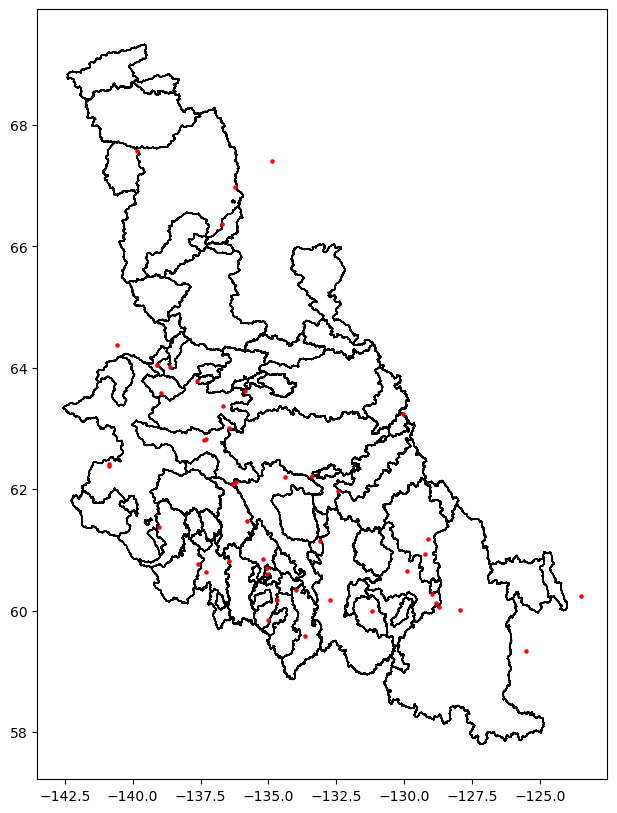

In [28]:
ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
stations_gdf.plot(ax=ax, marker='o', color='red', markersize=5)

<Axes: >

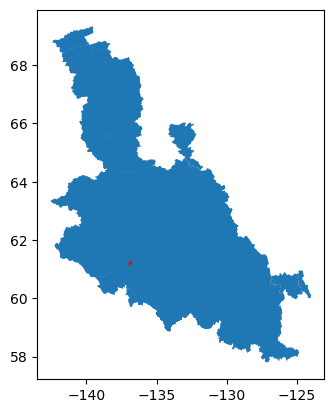

In [35]:
ax = gdf.plot()
gdf.loc[[4],:].plot(ax=ax, color="red")

In [91]:
from rasterio.features import geometry_mask
import rasterio
import numpy as np

def grid_to_poly(grid_x, grid_y, grid_z, gdf):

    # Create a raster template based on grid_x and grid_y
    transform = rasterio.transform.from_bounds(
        grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max(),
        grid_x.shape[1], grid_x.shape[0]
    )

    # Convert polygons to raster masks
    raster_masks = {idx: geometry_mask([geom], transform=transform, invert=True, out_shape=grid_x.shape) 
                    for idx, geom in gdf.geometry.items()}

    mean_values = {idx: grid_z[mask].mean() for idx, mask in raster_masks.items()}

    return mean_values


grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
grid_to_poly(grid_x, grid_y, grid_z, gdf)





ValueError: could not convert string to float: ''

In [93]:
values

id
27     611
87     518
125    363
147    460
170    548
193    553
216    744
236    226
259    283
292    320
315    404
338    644
361    402
384    419
407    382
428    409
451    588
474    705
497    403
536    462
559    302
582    783
602    382
625    502
648    556
668    433
691    398
714    515
737    733
759    744
815    370
838    248
857    331
Name: dc_freeze, dtype: Int64

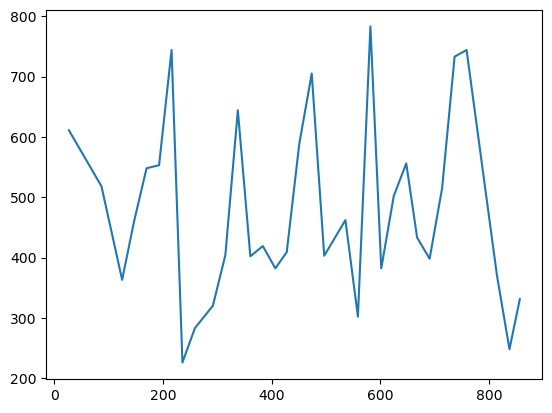

In [95]:
plt.plot(values)

<Axes: >

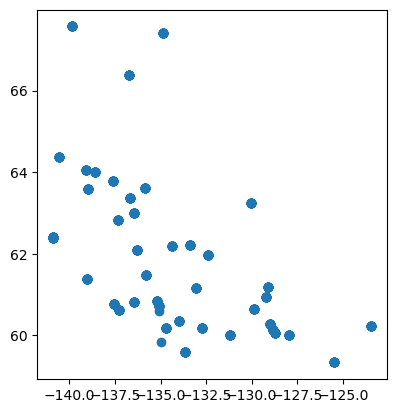

In [99]:
freeze.plot(data="values")

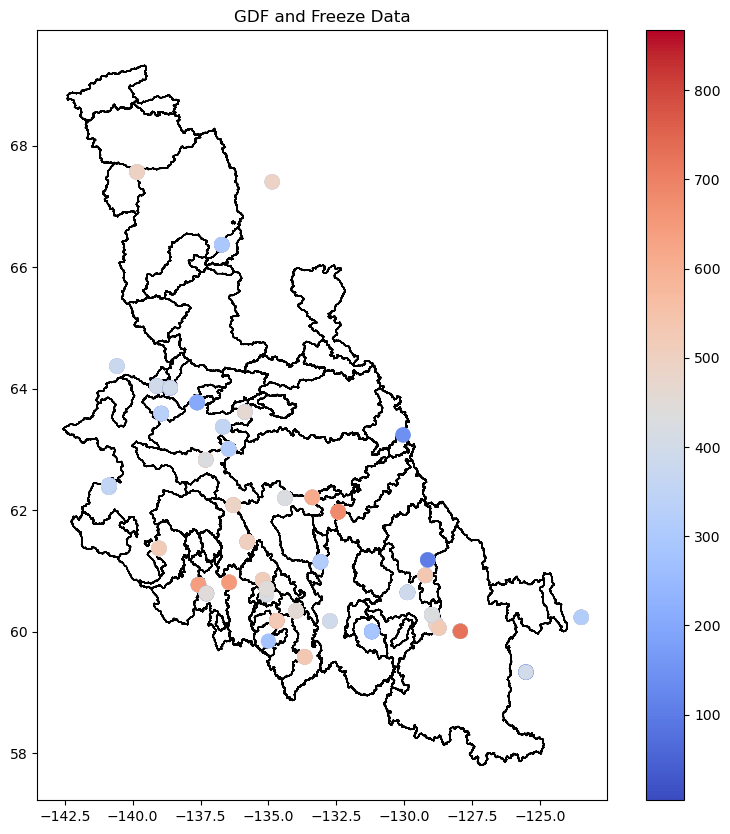

In [101]:
ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
freeze.plot(ax=ax, column="dc_freeze", legend=True, cmap="coolwarm", markersize=100)
plt.title("GDF and Freeze Data")
plt.show()

In [130]:
values

array([611., 518., 363., 460., 548., 553., 744., 226., 283., 320., 404.,
       644., 402., 419., 382., 409., 588., 705., 403., 462., 302., 783.,
       382., 502., 556., 433., 398., 515., 733., 744., 370., 248., 331.])

In [132]:
values

array([61.97892549, 40.54327245, 67.61598964, 28.53031173, 79.53440816,
       36.85469147, 92.07999568,  4.42373499, 27.15090968,  7.72931126,
       23.62556822, 10.3562123 , 41.35287931, 72.97334047, 73.56333798,
       78.07346802, 49.85324297, 36.37222984, 22.90893657, 44.41988959,
       53.21849071, 59.22984502, 15.11304478,  2.80121761, 15.88873875,
       23.70201078, 37.24392933, 87.96051405,  7.59251071, 87.05597737,
       78.4845776 , 44.45597004, 44.20384139])

In [195]:
values = freeze.loc[idx, "freeze_date"].dt.dayofyear.values
values

array([305, 289, 304, 293, 252, 304, 304, 292, 293, 301, 300, 237, 282,
       275, 305, 299, 282, 301, 300, 306, 306, 294, 290, 290, 305, 304,
       300, 306, 294, 291, 290, 291, 306, 292, 301, 306, 301, 306, 289])

In [ ]:



years = np.unique(freeze["freeze_date"].dt.year)
df = pd.DataFrame(index=years, columns=gdf.index)

for year in years:

    idx = (freeze["freeze_date"].dt.year == year) & freeze["dc_freeze"].notnull()
    #values = freeze.loc[idx, "dc_freeze"].astype(float).values
    values = freeze.loc[idx, "freeze_date"].dt.dayofyear.astype(float).values
    lats = freeze.loc[idx, "geometry"].y.values
    lons = freeze.loc[idx, "geometry"].x.values


    grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
    basin_avgs = grid_to_poly(grid_x, grid_y, grid_z, gdf)
    df.loc[year] = basin_avgs

In [215]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2002.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2003.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2004.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2005.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2006.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2007.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2008.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2009.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2010.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856
2011.0,288.916592,291.119506,290.600384,290.610932,290.871872,291.102342,289.359455,291.119506,286.586787,285.448861,...,296.673705,288.237212,286.538748,290.448347,300.041929,300.196327,293.933637,300.83622,300.42685,300.457856


In [193]:
freeze.explore()

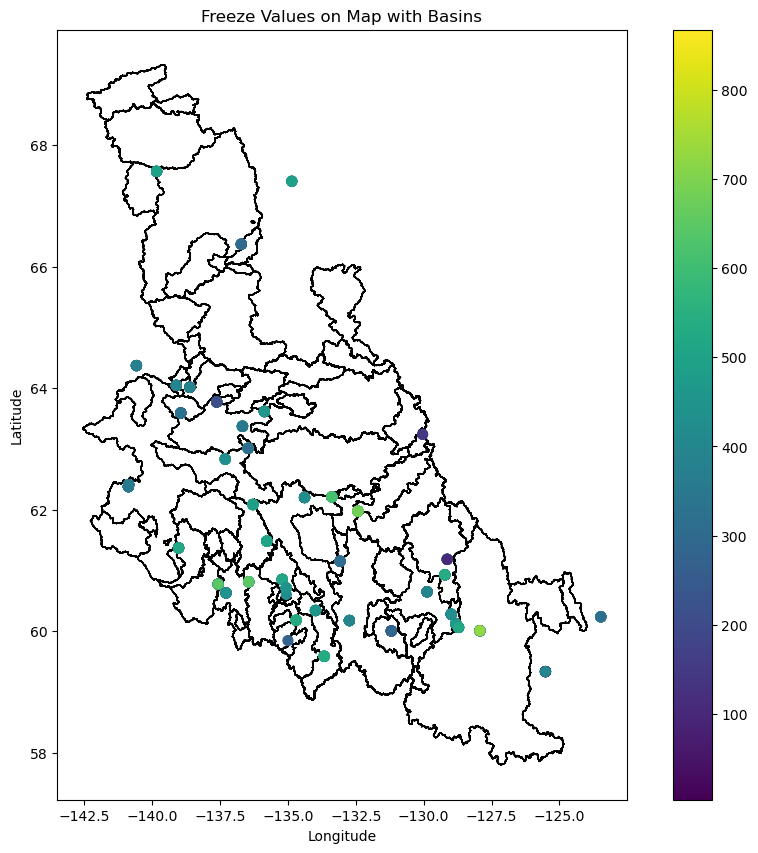

In [160]:
# Plot basins and freeze values
ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(12, 10))
freeze.plot(ax=ax, column="dc_freeze", legend=True, markersize=50)

# Add title and labels
plt.title("Freeze Values on Map with Basins")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()